In [48]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

%run ml_project_normalized.ipynb

Note: you may need to restart the kernel to use updated packages.
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [70]:
def optimize_thresholds(class_labels, class_probs_val, y_val_raw):
    """
    Optimize per-class thresholds using balanced accuracy on validation set.
    """
    print("\n=== [ Threshold Search using Balanced Accuracy on Validation Set ] ===")
    val_probs_matrix = np.vstack(class_probs_val[:len(class_labels)]).T
    optimized_thresholds = {}

    for i, cls in enumerate(class_labels):
        best_thresh = 0.5
        best_bal_acc = 0.0

        for t in np.arange(0.05, 0.91, 0.05):
            preds = pd.Series((val_probs_matrix[:, i] >= t)).map({True: cls, False: None})
            fallback_preds = []

            for j, val in enumerate(preds):
                if val is None:
                    alt_scores = {
                        c: val_probs_matrix[j, k]
                        for k, c in enumerate(class_labels) if c != 'Adoption'
                    }
                    val = max(alt_scores.items(), key=lambda x: x[1])[0]
                fallback_preds.append(val)

            bal_acc = balanced_accuracy_score(y_val_raw, fallback_preds)
            if bal_acc > best_bal_acc:
                best_bal_acc = bal_acc
                best_thresh = t

        best_thresh = min(best_thresh, 0.65)  # ✅ clip it *before* storing
        optimized_thresholds[cls] = best_thresh
        print(f"[Threshold] Class: {cls:15} | Optimal: {best_thresh:.2f} | Balanced Acc: {best_bal_acc:.4f}")

    return optimized_thresholds

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import cross_val_score
# from sklearn.calibration import CalibratedClassifierCV
# import matplotlib.pyplot as plt
# import seaborn as sns

# def train_classifier(X_train, y_train_raw, X_test, thresholds=None, base_model=None, X_val=None, y_val_raw=None):
#     """
#     Trains downsampled, calibrated OvR XGBoost models with fixed thresholds.
    
#     Returns:
#         final_predictions (Series): Final predicted labels on X_test
#         ovr_models (dict): Trained OvR models
#     """
#     class_labels = sorted(y_train_raw.unique())
#     ovr_models = {}
#     class_probs_test = []
#     class_probs_val = []
#     optimized_thresholds = thresholds or {cls: 0.5 for cls in class_labels}
#     enable_threshold_search = True

#     # Per-class tree depths
#     custom_depths = {
#         'Died': 10,
#         'Euthanasia': 8,
#         'Adoption': 6,
#         'Return to Owner': 6,
#         'Transfer': 6
#     }

#     print("\n=== [ OvR Model Training with Downsampling and Fixed Thresholds ] ===")
#     for target_class in class_labels:
#         print(f"\n[INFO] Training OvR model for class: '{target_class}'")

#         # Binary target
#         y_binary = (y_train_raw == target_class).astype(int)

#         # === [1] Downsample majority class ===
#         pos_indices = y_binary[y_binary == 1].index
#         neg_indices = y_binary[y_binary == 0].index
#         n_pos = len(pos_indices)
#         n_neg = len(neg_indices)

#         if n_pos == 0:
#             print(f"[WARN] No positive samples for class '{target_class}', skipping.")
#             continue

#         if n_neg > n_pos:
#             neg_sample_indices = np.random.choice(neg_indices, size=n_pos, replace=False)
#             selected_indices = np.concatenate([pos_indices, neg_sample_indices])
#         else:
#             selected_indices = y_binary.index

#         X_train_bal = X_train.loc[selected_indices]
#         y_binary_bal = y_binary.loc[selected_indices]

#         print(f"[DEBUG] '{target_class}' class balance: {y_binary_bal.value_counts().to_dict()}")

#         X_train_bal = X_train
#         y_binary_bal = (y_train_raw == target_class).astype(int)

#         # === [2] Train calibrated XGBoost ===
#         depth = custom_depths.get(target_class, 6)

#         base_clf = XGBClassifier(
#             objective='binary:logistic',
#             eval_metric='logloss',
#             n_estimators=250,
#             max_depth=depth,
#             learning_rate=0.1,
#             subsample=0.8,  
#             colsample_bytree=0.8,
#             random_state=42,
#             n_jobs=-1
#         )

#         clf = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv=3)

#         print("[INFO] 5-Fold CV (balanced accuracy):")
#         scores = cross_val_score(clf, X_train_bal, y_binary_bal, cv=5, scoring='balanced_accuracy', n_jobs=-1)
#         for i, score in enumerate(scores):
#             print(f"  Fold {i+1}: {score:.4f}")
#         print(f"  Mean CV score: {scores.mean():.4f}")

#         clf.fit(X_train_bal, y_binary_bal)
#         ovr_models[target_class] = clf

#         # Predict proba for final test set
#         class_probs_test.append(clf.predict_proba(X_test)[:, 1])
#         if X_val is not None and y_val_raw is not None:
#             class_probs_val.append(clf.predict_proba(X_val)[:, 1])

#     if X_val is not None and y_val_raw is not None and enable_threshold_search:
#         optimized_thresholds = optimize_thresholds(class_labels, class_probs_val, y_val_raw)
#     else:
#         optimized_thresholds = thresholds or {cls: 0.5 for cls in class_labels}


#     # === [Final Prediction on X_test] ===
#     print("\n=== [ Predicting Test Set with Thresholds ] ===")
#     test_probs_matrix = np.vstack(class_probs_test[:len(class_labels)]).T

#     def predict_labels(prob_matrix):
#         final_preds = []
#         fallback_count = 0

#         for prob_row in prob_matrix:
#             scores = dict(zip(class_labels, prob_row))
#             selected_class = None
#             selected_score = 0

#             for cls, score in scores.items():
#                 threshold = optimized_thresholds.get(cls, 0.5)
#                 if score >= threshold and score > selected_score:
#                     selected_class = cls
#                     selected_score = score

#             if not selected_class:
#                 selected_class = max(scores.items(), key=lambda x: x[1])[0]  # just pick top class
#                 fallback_count += 1

#             final_preds.append(selected_class)

#         return pd.Series(final_preds), fallback_count

#     final_predictions, fallback_count = predict_labels(test_probs_matrix)
#     print(f"[INFO] Fallbacks used for {fallback_count} test samples")

#     # === [Training Set Accuracy] ===
#     print("\n=== [ Generalization Accuracy on Training Set ] ===")
#     train_probs_matrix = np.vstack([
#         ovr_models[cls].predict_proba(X_train)[:, 1] for cls in class_labels
#     ]).T
#     train_preds, fallback_train = predict_labels(train_probs_matrix)
#     print(f"[INFO] Training Accuracy:          {accuracy_score(y_train_raw, train_preds):.4f}")
#     print(f"[INFO] Training Balanced Accuracy: {balanced_accuracy_score(y_train_raw, train_preds):.4f}")
#     print(f"[INFO] Training Fallbacks:         {fallback_train}")

#     # === [Validation Accuracy] ===
#     if X_val is not None and y_val_raw is not None:
#         print("\n=== [ Validation Set Accuracy ] ===")
#         val_probs_matrix = np.vstack(class_probs_val[:len(class_labels)]).T
#         val_preds, fallback_val = predict_labels(val_probs_matrix)
#         print(f"[INFO] Validation Accuracy:          {accuracy_score(y_val_raw, val_preds):.4f}")
#         print(f"[INFO] Validation Balanced Accuracy: {balanced_accuracy_score(y_val_raw, val_preds):.4f}")
#         print(f"[INFO] Validation Fallbacks:         {fallback_val}")

#     # === [Heatmap] ===
#     sample_size = min(100, len(test_probs_matrix))
#     sample_probs = pd.DataFrame(test_probs_matrix[:sample_size, :len(class_labels)], columns=class_labels)
#     plt.figure(figsize=(14, 6))
#     sns.heatmap(sample_probs, cmap="viridis", annot=False, cbar=True)
#     plt.title("OvR Class Probabilities (First 100 Test Samples)")
#     plt.xlabel("Class")
#     plt.ylabel("Sample Index")
#     plt.tight_layout()
#     plt.show()

#     return final_predictions, ovr_models


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV

def train_classifier(X_train, y_train_raw, X_test, thresholds=None, base_model=None, X_val=None, y_val_raw=None):
    """
    Trains OvR XGBoost models with per-class RandomizedSearchCV, optional calibration and threshold tuning.
    
    Returns:
        final_predictions (Series): Predictions for X_test
        ovr_models (dict): Trained OvR models
    """
    

    class_labels = sorted(y_train_raw.unique())
    ovr_models = {}
    class_probs_test = []
    class_probs_val = []
    enable_threshold_search = True  # toggle on/off for threshold optimization

    # Depth guide per class (used for early param suggestion)
    custom_depths = {
        'Died': 15,
        'Euthanasia': 10,
        'Adoption': 6,
        'Return to Owner': 6,
        'Transfer': 6
    }

    print("\n=== [ OvR Training with RandomizedSearchCV and Calibration ] ===")
    for target_class in class_labels:
        print(f"\n[INFO] Training OvR model for class: '{target_class}'")

        y_binary = (y_train_raw == target_class).astype(int)

        # === [Downsampling] ===
        pos_idx = y_binary[y_binary == 1].index
        neg_idx = y_binary[y_binary == 0].index
        n_pos = len(pos_idx)
        n_neg = len(neg_idx)

        if n_pos == 0:
            print(f"[WARN] No positives for '{target_class}', skipping.")
            continue

        if n_neg > n_pos:
            sampled_neg = np.random.choice(neg_idx, size=n_pos, replace=False)
            selected_idx = np.concatenate([pos_idx, sampled_neg])
        else:
            selected_idx = y_binary.index

        X_train_bal = X_train.loc[selected_idx]
        y_binary_bal = y_binary.loc[selected_idx]

        print(f"[DEBUG] '{target_class}' class balance: {y_binary_bal.value_counts().to_dict()}")

        # === [Hyperparameter Search] ===
        scale_pos_weight = (y_binary_bal == 0).sum() / max((y_binary_bal == 1).sum(), 1)

        param_grid = {
            'max_depth': [4, 6, 8, 10, 12],
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
        }

        base_xgb = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1
        )

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        search = RandomizedSearchCV(
            estimator=base_xgb,
            param_distributions=param_grid,
            scoring='balanced_accuracy',
            n_iter=10,
            cv=skf,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train_bal, y_binary_bal)
        best_model = search.best_estimator_

        print(f"[INFO] Best Params for '{target_class}': {search.best_params_}")
        print(f"[INFO] Best CV Score: {search.best_score_:.4f}")

        # === [Calibration] ===
        clf = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv=skf)
        clf.fit(X_train_bal, y_binary_bal)

        ovr_models[target_class] = clf
        class_probs_test.append(clf.predict_proba(X_test)[:, 1])
        if X_val is not None and y_val_raw is not None:
            class_probs_val.append(clf.predict_proba(X_val)[:, 1])

    # === [Thresholds] ===
    if enable_threshold_search and X_val is not None and y_val_raw is not None:
        optimized_thresholds = optimize_thresholds(class_labels, class_probs_val, y_val_raw)
    else:
        optimized_thresholds = thresholds or {cls: 0.5 for cls in class_labels}
        print("[INFO] Using static thresholds:", optimized_thresholds)

    # === [Prediction Logic] ===
    def predict_labels(prob_matrix):
        final_preds = []
        fallback_count = 0

        for prob_row in prob_matrix:
            scores = dict(zip(class_labels, prob_row))
            selected_class = None
            selected_score = 0

            for cls, score in scores.items():
                threshold = optimized_thresholds.get(cls, 0.5)
                if score >= threshold and score > selected_score:
                    selected_class = cls
                    selected_score = score

            if not selected_class:
                selected_class = max(scores.items(), key=lambda x: x[1])[0]
                fallback_count += 1

            final_preds.append(selected_class)

        return pd.Series(final_preds), fallback_count

    print("\n=== [ Predicting Test Set ] ===")
    test_probs_matrix = np.vstack(class_probs_test[:len(class_labels)]).T
    final_predictions, fallback_count = predict_labels(test_probs_matrix)
    print(f"[INFO] Fallbacks used for {fallback_count} test samples")

    # === [Training Accuracy] ===
    print("\n=== [ Generalization Accuracy on Training Set ] ===")
    train_probs_matrix = np.vstack([
        ovr_models[cls].predict_proba(X_train)[:, 1] for cls in class_labels
    ]).T
    train_preds, fallback_train = predict_labels(train_probs_matrix)
    print(f"[INFO] Training Accuracy:          {accuracy_score(y_train_raw, train_preds):.4f}")
    print(f"[INFO] Training Balanced Accuracy: {balanced_accuracy_score(y_train_raw, train_preds):.4f}")
    print(f"[INFO] Training Fallbacks:         {fallback_train}")

    if X_val is not None and y_val_raw is not None:
        print("\n=== [ Validation Accuracy ] ===")
        val_probs_matrix = np.vstack(class_probs_val[:len(class_labels)]).T
        val_preds, fallback_val = predict_labels(val_probs_matrix)
        print(f"[INFO] Validation Accuracy:          {accuracy_score(y_val_raw, val_preds):.4f}")
        print(f"[INFO] Validation Balanced Accuracy: {balanced_accuracy_score(y_val_raw, val_preds):.4f}")
        print(f"[INFO] Validation Fallbacks:         {fallback_val}")

    # === [Heatmap] ===
    sample_size = min(100, len(test_probs_matrix))
    sample_probs = pd.DataFrame(test_probs_matrix[:sample_size, :len(class_labels)], columns=class_labels)
    plt.figure(figsize=(14, 6))
    sns.heatmap(sample_probs, cmap="viridis", annot=False, cbar=True)
    plt.title("OvR Class Probabilities (First 100 Test Samples)")
    plt.xlabel("Class")
    plt.ylabel("Sample Index")
    plt.tight_layout()
    plt.show()

    return final_predictions, ovr_models

Encoding mapping: {'Adoption': 0, 'Died': 1, 'Euthanasia': 2, 'Return to Owner': 3, 'Transfer': 4}
Rare classes (by encoded value):
  2: Euthanasia
  1: Died

=== [ OvR Training with RandomizedSearchCV and Calibration ] ===

[INFO] Training OvR model for class: 'Adoption'
[DEBUG] 'Adoption' class balance: {1: 35778, 0: 35778}
[INFO] Best Params for 'Adoption': {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
[INFO] Best CV Score: 0.7053

[INFO] Training OvR model for class: 'Died'
[DEBUG] 'Died' class balance: {1: 677, 0: 677}
[INFO] Best Params for 'Died': {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
[INFO] Best CV Score: 0.7444

[INFO] Training OvR model for class: 'Euthanasia'
[DEBUG] 'Euthanasia' class balance: {1: 2242, 0: 2242}
[INFO] Best Params for 'Euthanasia': {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


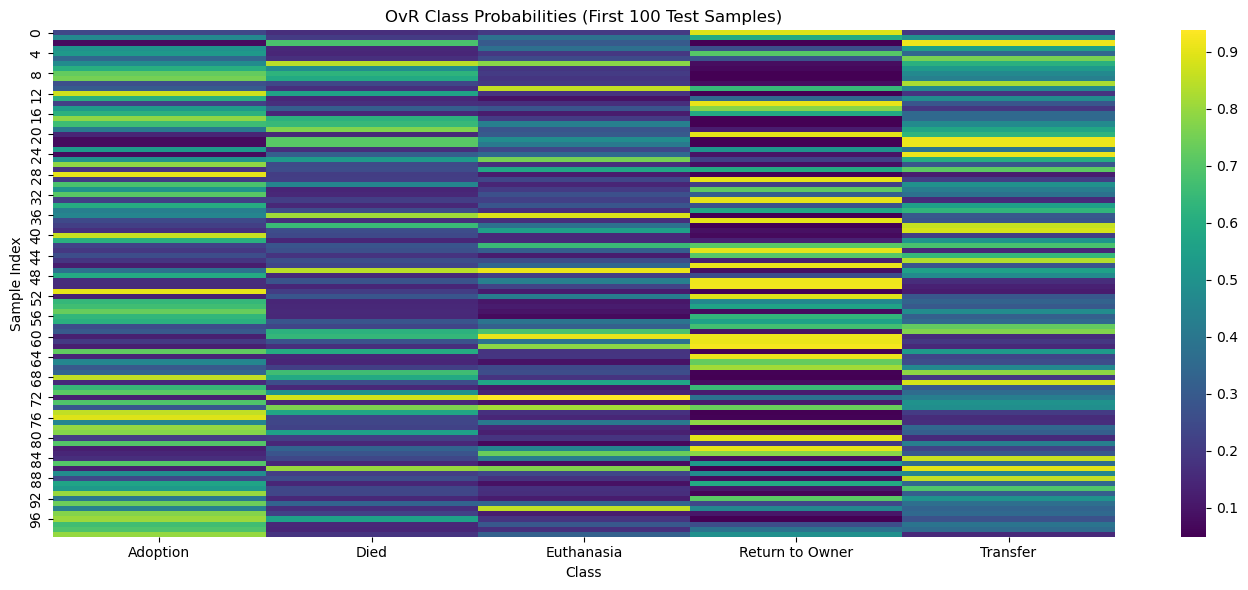

Combined test predictions saved to: ./test_multi_ovr_with_thresholds_predictions_combined.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# === [1] EXTRA DATA CLEANING ===
df_train = bucket_seasons(df_train)
df_test  = bucket_seasons(df_test)

# Separate target
y_raw_full = df_train['outcome_type']
X_full = df_train.drop(columns=['outcome_type', 'is_mix', 'intake_hour', 'intake_month'])

# === [2] Label encode outcome_type for reporting and consistency ===
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw_full)
print("Encoding mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# === [3] Identify rare classes (< 5% frequency, for logging/debugging) ===
rare_classes = [
    label for label, count in pd.Series(y_encoded).value_counts().items()
    if count < 0.05 * len(y_encoded)
]
print("Rare classes (by encoded value):")
for cls in rare_classes:
    print(f"  {cls}: {le.classes_[cls]}")

# === [4] DATA SPLITTING ===
X_train, X_temp, y_train_raw, y_temp_raw = train_test_split(
    X_full, y_raw_full, test_size=0.35, stratify=y_raw_full, random_state=42
)

X_val, X_test, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp_raw, test_size=0.57, stratify=y_temp_raw, random_state=42
)
# Results in approx: 65% train / 15% val / 20% test

# === [5] CATEGORICAL FEATURE ENCODING ===
categorical_cols = ['intake_type', 'intake_condition', 'animal_type',
                    'sex_upon_intake', 'season', 'breed', 'primary_color']

for col in categorical_cols:
    # Convert training to category
    X_train[col] = X_train[col].astype("category")

    # Apply training categories to val/test
    X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
    X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

    # Convert to integer codes (unknowns -> -1)
    X_train[col] = X_train[col].cat.codes
    X_val[col] = X_val[col].cat.codes
    X_test[col] = X_test[col].cat.codes

# Save raw training version for analysis if needed
raw_X_train = X_train.copy()

# Ensure test set has all expected columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# === [6] DEFINE DEFAULT THRESHOLDS ===
thresholds = {
    'Adoption': 0.60,
    'Died': 0.10,
    'Euthanasia': 0.10,
    'Return to Owner': 0.15,
    'Transfer': 0.55
}

# === [7] TRAIN OVR MODEL AND PREDICT ===
final_predictions, ovr_models = train_classifier(
    X_train=X_train,
    y_train_raw=y_train_raw,
    X_test=X_test,  # Change to X_val if validating
    thresholds=thresholds,
    X_val=X_val,
    y_val_raw=y_val_raw
)

# === [8] SAVE FINAL PREDICTIONS ===
save_predictions(final_predictions, model_name='ovr_xg_boost')